# 7주차 스터디

**퀀트 입문**

    1. MDD 계산

    2. 포트폴리오의 수익, 분산 구하기

    3. Efficient Frontier 구하기

    4. 주식(포트폴리오)의 베타 계산

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## MDD 계산

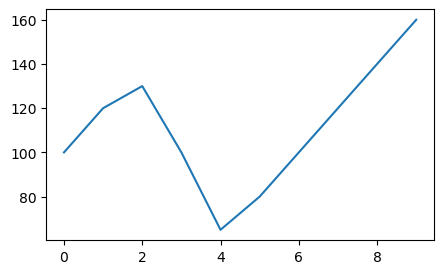

In [2]:
asset_a = np.array([100,120,130,100,65,80,100,120,140,160])

plt.figure(figsize=(5,3))
plt.plot(range(len(asset_a)), asset_a);

In [3]:
# Max 값을 누적해서 쌓는다
accum = np.maximum.accumulate(asset_a)
accum

array([100, 120, 130, 130, 130, 130, 130, 130, 140, 160], dtype=int32)

In [4]:
# DrawDown을 구하고, 그 중, 최솟값인 MDD를 구한다
DD = asset_a - accum
MDD = np.min(DD / accum)
MDD

-0.5

## 포트폴리오의 수익, 분산 구하기

기대수익률:  $W$ $\cdot$ $E(R)$

분산 :   $W^T$ $\cdot$ $\sum$ $\cdot$ $W$   

In [5]:
stock_close = pd.DataFrame()

for name in ["HMM","삼성전자","에쓰오일","에코프로","엔씨소프트","현대차"]:
    stock_close[name] = pd.read_csv("데이터/{}주가.csv".format(name), 
                                    index_col=0, parse_dates=True).Close
    
stock_close

,HMM,삼성전자,에쓰오일,에코프로,엔씨소프트,현대차
Date,,,,,,
2018-01-02,5010,51020,117000,25698,446500,149500
2018-01-03,4790,51620,113500,24630,435000,150500
2018-01-04,4625,51080,113500,23918,422500,146500
2018-01-05,4635,52120,113000,24727,422000,149000
2018-01-08,4520,52020,111500,24144,420000,151000
...,...,...,...,...,...,...
2022-12-23,21700,58100,88000,108595,429500,157000
2022-12-26,21750,57900,89500,110926,432000,158000
2022-12-27,21850,58100,89100,111800,432000,158000


##### 1. Equal Weight인 경우 (1/6씩)

In [6]:
# weight 행렬 만들기
weight = np.array([1/6]*6)
weight

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In [7]:
# 포트폴리오의 기대 수익률 계산 (일간 수익률의 평균을 기대수익률로 사용) 
# 일간 수익률을 연간 수익률로 환산하기 위해서 250을 곱해줌
# (1년 중 영업일은 보통 250일)
mean_return = stock_close.pct_change().mean() * 250

np.dot(weight, mean_return)

0.17565084327134695

In [8]:
# 포트폴리오의 위험(분산) 계산
sigma = stock_close.pct_change().cov() * 250

np.dot(weight, np.dot(sigma, weight.T))

0.06205968075122592

##### 2. Animal Sprit인 경우 

에코프로에 포트폴리오의 절반을 담아보자

In [9]:
# weight 행렬 만들기
weight = np.array([0.1, 0.1,0.1,0.5,0.1,0.1])
weight

array([0.1, 0.1, 0.1, 0.5, 0.1, 0.1])

In [10]:
# 포트폴리오의 기대 수익률 계산 (일간 수익률의 평균을 기대수익률로 사용) 
mean_return = stock_close.pct_change().mean() * 250

np.dot(weight, mean_return)

0.2863272927045341

In [11]:
# 포트폴리오의 위험(분산) 계산
sigma = stock_close.pct_change().cov() * 250

np.dot(weight.T, np.dot(sigma, weight))

0.12477589559969107

## Efficient Frontier 만들기

In [12]:
stock_pct = stock_close.pct_change().mean() * 250
sigma = stock_close.pct_change().cov() * 250

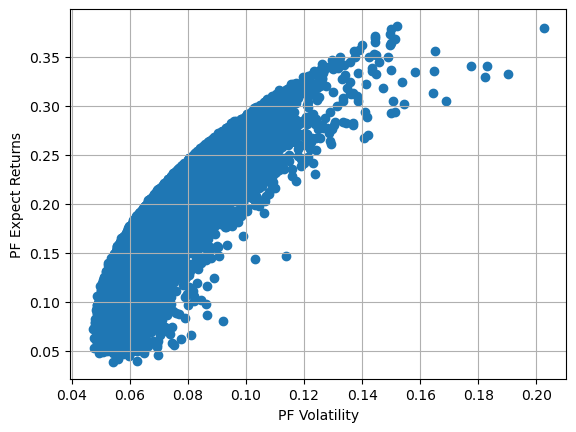

In [13]:
# 30000개의 랜덤한 weight를 가진 포트폴리오를 만든다
n_port = 30_000

pf_return = []
pf_vol = []
pf_weight = []

for _ in range(n_port):
    weight = np.random.random(6)
    weight /= np.sum(weight)
    # 기대수익 저장
    pf_return.append(np.dot(weight, mean_return))
    # 변동성 저장
    pf_vol.append(np.dot(weight.T, np.dot(sigma, weight)))
    # 비중 저장
    pf_weight.append(weight)

# 그림으로 그려보기
plt.scatter(pf_vol, pf_return)
plt.xlabel("PF Volatility")
plt.ylabel("PF Expect Returns")
plt.grid();

최소분산 포트폴리오 비중은:  [0.02663984 0.46113456 0.15783715 0.03557764 0.14706602 0.1717448 ]


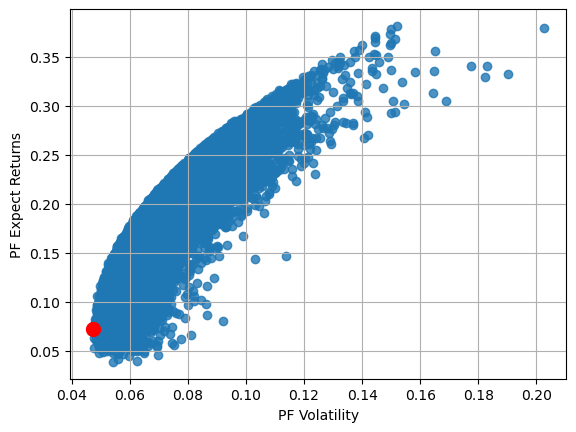

In [14]:
# 최소분산 포트폴리오를 찾아봅시다

min_idx = np.argmin(pf_vol)

ret = pf_return[min_idx]
vol = pf_vol[min_idx]
print("최소분산 포트폴리오 비중은: ", pf_weight[min_idx])

# 기존에 구해둔 Efficient frontier 그리기
plt.scatter(pf_vol, pf_return, alpha=0.8)
plt.xlabel("PF Volatility")
plt.ylabel("PF Expect Returns")
plt.grid()

# 최소분산 포트폴리오는 빨간 점으로 표시
plt.scatter(vol,ret, c='r', s=100);

## 베타($\beta$)를 계산해보자

베타란 주식시장의 전체 변동에 대한 개별 종목의 변동 정도를 측정한다 

베타는 개별 주식에 국한되는 개념은 아니고, 포트폴리오에 대해서도 계산할 수 있다. 포트폴리오의 개별 종목의 베타를 비중으로 가중평균 한 것이 포트폴리오의 베타가 된다

윈도우 크기에 따라 베타 값은 달라지게 된다

---

$\beta$를 구하는 두 가지 방법

1. 시장포트폴리오의 수익을 개별 자산의 수익에 회귀분석해서 구한다

2. $\beta =$ $\sigma_{im}\over\sigma^2_m$ : 자산 i와 시장포트폴리오의 공분산을 시장포트폴리오의 분산으로 나눈 것이다

In [15]:
market = pd.read_excel("데이터/지수.xlsx", index_col=0)
market.index.name = None #거슬리는거 제거
market

,코스피,코스닥
2018-01-02,2479.65,812.45
2018-01-03,2486.35,822.31
2018-01-04,2466.46,808.01
2018-01-05,2497.52,828.03
2018-01-08,2513.28,839.51
...,...,...
2022-12-23,2313.69,691.25
2022-12-26,2317.14,694.68
2022-12-27,2332.79,704.19
2022-12-28,2280.45,692.37


첫번째 방법(회귀분석)

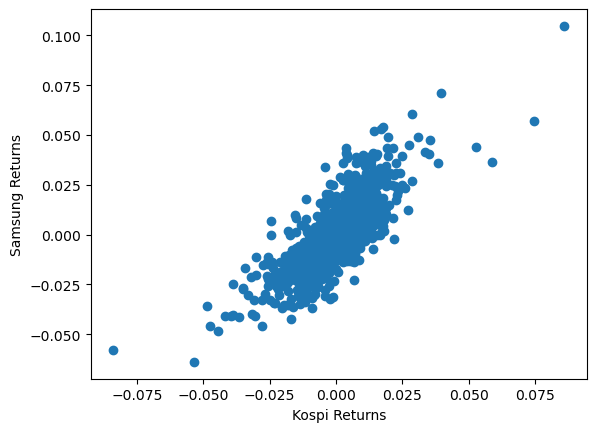

In [16]:
# 삼성전자의 베타 구해보기 (window는 1년)
samsung = stock_close.삼성전자

samsung_pct = samsung.pct_change().dropna().values
market_pct = market.코스피.pct_change().dropna().values

plt.scatter(market_pct, samsung_pct)
plt.xlabel("Kospi Returns")
plt.ylabel("Samsung Returns");

모델의 기울기(베타):  1.0810016453106452


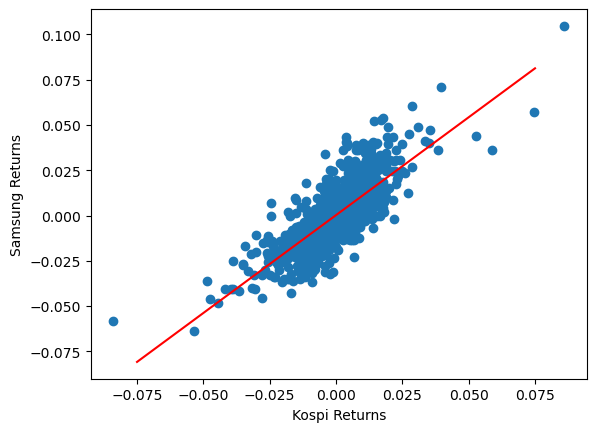

In [17]:
# Regression Line 그려보기
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(market_pct.reshape(-1,1),samsung_pct)

# 삼성전자의 5년간 베타를 의미함
print("모델의 기울기(베타): ", model.coef_[0])

x = [[-0.075],[0.075]]
y = model.predict(x)

# 회귀선 그리기
plt.plot(x,y, c="r")

# 기존 수익 산점도 그리기 
plt.scatter(market_pct, samsung_pct)
plt.xlabel("Kospi Returns")
plt.ylabel("Samsung Returns");

두번째 방법 (공식으로)

$\beta =$ $\sigma_{im}\over\sigma^2_m$

In [18]:
df = pd.DataFrame(np.c_[market_pct, samsung_pct], 
             columns=["코스피","삼성전자"])

sigma_m = df.코스피.var()
sigma_im = df.cov().iloc[0,1]

# 삼성전자의 5년간 베타
sigma_im / sigma_m

1.0810016453106441

## 퀀트 전략 구현하고 평가하기

20일 이동 평균선을 돌파하면 "그 다음날" 주식을 사고, 그 반대일 때는 "그 다음날" 파는 전략을 구현해봅시다

In [29]:
data = pd.DataFrame(stock_close.에코프로.values,
                    index=stock_close.index,
                    columns=["price"])

In [30]:
# 이평선 계산
data['ma'] = data['price'].rolling(window=20).mean()

# 값 초기화
bought = 0
init_value = 10_000_000
value_list = {"2018-01-01":init_value}

# 반복
for i in range(len(data)):
    if bought == 0 and data['price'][i] > data['ma'][i]:
        # Buy the stock
        bought = 1
        buy_price = data['price'][i+1]
        n_stock = init_value // buy_price # 몇 주 사는지 계산

    elif bought == 1 and data['price'][i] < data['ma'][i]:
        # Sell the stock
        bought = 0
        sell_price = data['price'][i+1]
        gain = sell_price - buy_price
        init_value += n_stock * gain
        value_list[str(data.index[i])[:10]] = init_value
        n_stock = 0

# 마지막까지 주식을 들고 있는 경우(다 판다)
if n_stock > 0:
    sell_price = data['price'][-1]
    gain = sell_price - buy_price
    init_value += n_stock * gain
    n_stock = 0
    value_list["2022-12-30"] = init_value

print(init_value)
print(n_stock)

44711529
0


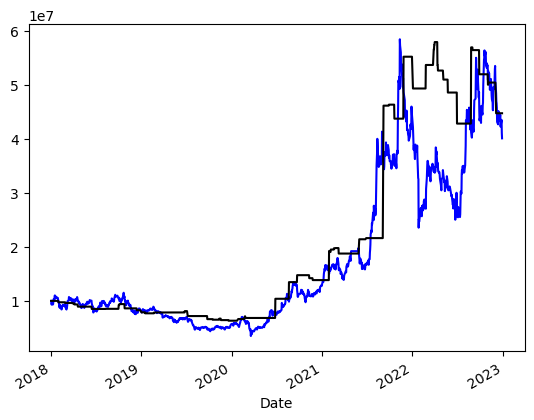

In [31]:
# 그냥 사서 들고 있는 전략 
(data.price * (10_000_000 // data.price[0])).plot(c='b')

# 이평선 돌파 전략
se = pd.Series(value_list)
se.index = pd.to_datetime(se.index)
se = se.reindex(index=data.index)
se["2018-01-02"] = 10_000_000
se = se.ffill()
se.plot(c='k');